# NER Analysis

In [1]:
import pandas as pd
import numpy as np
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
font = {'size'   : 18}
mpl.rc('font', **font) 

In [3]:

def plot_coefficients(classifier, feature_names, figurename, savePlt=False, top_features=10):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 font = {'size'   : 18}
 mpl.rc('font', **font) 
 fig, ax= plt.subplots(1, 1, figsize=(11,5)) 
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 ax.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
#  ax.set_yticks([-1, 0, 1])
 ax.set_xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=40, ha='right', rotation_mode="anchor")
 ax.set_ylabel('Text')
 if savePlt:
    plt.savefig('Graphs/impFeatureImp_' + figurename + '.pdf', format="pdf", bbox_inches="tight")
 plt.show()

## Wine

In [4]:
# Read
wine1 = pd.read_csv("Data/Wine/winemag-data-130k-v2.csv", index_col=0)
wine2 = pd.read_csv("Data/Wine/winemag-data_first150k.csv", index_col=0)
wineRevs = pd.concat([wine1, wine2])
print(wineRevs.columns)

# Rename
wineRevs = wineRevs[['description', 'points']]

# Remove duplicates 
print(wineRevs.shape)
wineRevs = wineRevs.drop_duplicates(subset=['description']).reset_index(drop=True)
print('-----')
print(wineRevs.shape)
wineRevs[1:5]

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')
(280901, 2)
-----
(169430, 2)


,description,points
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [5]:
nlp = spacy.load("en_core_web_lg")
description = []
for desc in wineRevs['description']:
    tempStr = desc                          
    doc = nlp(desc)                         
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'FAC', 'PERSON', 'PRODUCT', 'NORP']:
            tempStr = tempStr.replace(ent.text,' ')
    description.append(tempStr)
wineRevs['description'] = description

In [6]:
description = []
for desc in wineRevs['description']:
    doc = nlp(desc) 
    description.append(' '.join([token.lemma_ for token in doc if (not token.is_stop and token.is_alpha)]))
wineRevs['description'] = description

In [7]:
df_wine = wineRevs.copy()
points = []
for row in df_wine.points:
    if row < 90:
        points.append(0)
    else:
        points.append(1)

df_wine['points'] = points

In [8]:
train_x, test_x, train_y, test_y = train_test_split(df_wine.description, df_wine.points, train_size=0.8, random_state=50)

In [9]:
cv = CountVectorizer()
X_train = cv.fit_transform(train_x)
X_test = cv.transform(test_x)

In [10]:
classifier_naive = MultinomialNB()
test = classifier_naive.fit(X_train, train_y)
prediction_naive = classifier_naive.predict(X_test)
print(classification_report(test_y, prediction_naive))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84     21667
           1       0.70      0.77      0.73     12219

    accuracy                           0.80     33886
   macro avg       0.78      0.79      0.78     33886
weighted avg       0.80      0.80      0.80     33886



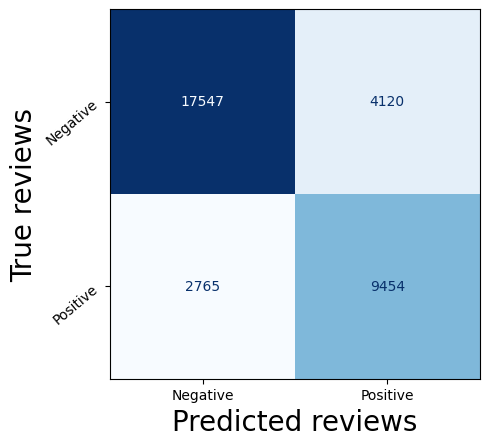

In [24]:
cm_svm = ConfusionMatrixDisplay.from_estimator(classifier_naive, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()

In [11]:
svm = LinearSVC(dual=False)
svm.fit(X_train, train_y)
prediction_svm = svm.predict(X_test)
print(classification_report(test_y, prediction_svm))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     21667
           1       0.78      0.72      0.75     12219

    accuracy                           0.83     33886
   macro avg       0.82      0.80      0.81     33886
weighted avg       0.82      0.83      0.83     33886



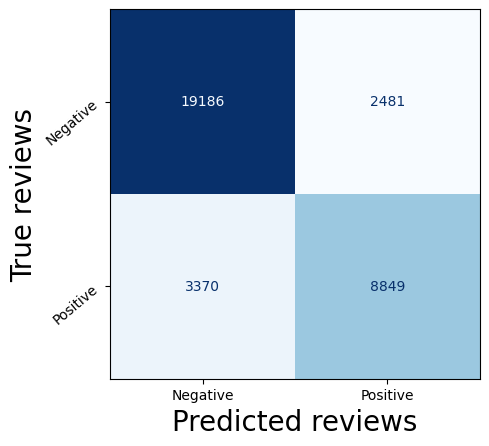

In [26]:
cm_svm = ConfusionMatrixDisplay.from_estimator(svm, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()

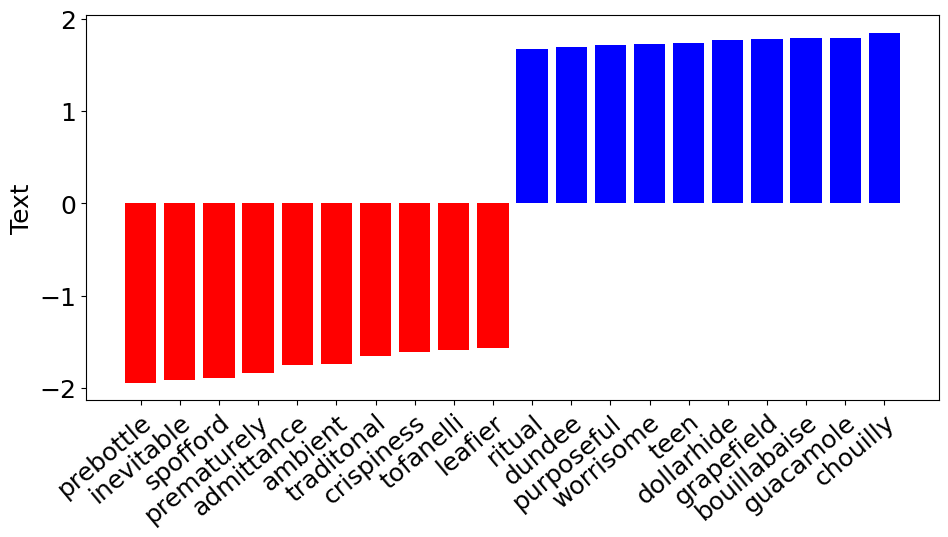

In [12]:
plot_coefficients(svm, cv.get_feature_names_out(), 'Wine')

In [ ]:
# hmmm interesting! still not able to recognize all

In [52]:
nlp = spacy.load("en_core_web_lg")
target = 'Dundee'
for desc in wineRevs.description:
    if target in desc:
        doc = nlp(desc)
        print(desc)
        for ent in doc.ents:
            print(ent.text, ent.label_)
        
        
# Dollarhide PRODUCT

Stoller offer fine value entire portfolio solidly craft estate grow heart Dundee Hills AVA gentle touch new oak flavorful mix strawberry cherry orange moderate alcohol signal balanced wine ample acidity drink
Stoller ORG
Dundee Hills GPE
bold strike wine estate vineyard black cherry capture core flavor Dundee Hills AVA substantial somewhat grainy tannin highlight coffee ground add dark note pair thick wild catch salmon steak
Dundee Hills GPE
good fine flight Pinots offer succulent mix crush flower berry liquid rock flavor meld beautifully vivid lively acidity bring touch grapefruit label read vineyard Dundee Hills AVA
Pinots ORG
Dundee Hills AVA ORG
Forward fruity flavorful pretty compendium raspberry cherry fruit accent touch orange peel pricy cuvées spend month quarter new oak label simply Willamette Valley fruit source principally prestigious Dundee Hills AVA
spend month quarter DATE
Willamette Valley PERSON
Dundee Hills AVA FAC
vineyard locate Dundee Hills AVA show label metallic e

## Whiskey

In [13]:
# Read
whiskeyRevs = pd.read_csv("Data/Whiskey/scotch_review.csv ", index_col=0)
print(whiskeyRevs.columns)

# Rename
whiskeyRevs = whiskeyRevs[['description', 'review.point']].rename(columns={'review.point' : 'points'})
print(whiskeyRevs.shape)

# Remove duplicates 
whiskeyRevs = whiskeyRevs.drop_duplicates(subset=['description']).reset_index(drop=True)
print('-----')
print(whiskeyRevs.shape)
whiskeyRevs[1:5]

Index(['name', 'category', 'review.point', 'price', 'currency', 'description'], dtype='object')
(2247, 2)
-----
(2245, 2)


,description,points
1,What impresses me most is how this whisky evol...,97
2,There have been some legendary Bowmores from t...,97
3,With a name inspired by a 1926 Buster Keaton m...,96
4,"Captivating, enticing, and wonderfully charmin...",96


In [14]:
nlp = spacy.load("en_core_web_lg")
description = []
for desc in whiskeyRevs['description']:
    tempStr = desc                          
    doc = nlp(desc)                         
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'FAC', 'PERSON', 'PRODUCT', 'NORP']:
            tempStr = tempStr.replace(ent.text,' ')
    description.append(tempStr)
whiskeyRevs['description'] = description

In [15]:
description = []
for desc in whiskeyRevs['description']:
    doc = nlp(desc) 
    description.append(' '.join([token.lemma_ for token in doc if (not token.is_stop and token.is_alpha)]))
whiskeyRevs['description'] = description

In [16]:
df_whiskey = whiskeyRevs.copy()
points = []
for row in df_whiskey.points:
    if row < 90:
        points.append(0)
    else:
        points.append(1)

df_whiskey['points'] = points

In [17]:
train_x, test_x, train_y, test_y = train_test_split(df_whiskey.description, df_whiskey.points, train_size=0.8, random_state=50)

In [18]:
X_train = cv.transform(train_x)
X_test = cv.transform(test_x)

In [19]:
prediction_naive = classifier_naive.predict(X_test)
print(classification_report(test_y, prediction_naive))

              precision    recall  f1-score   support

           0       0.85      0.50      0.63       330
           1       0.35      0.75      0.48       119

    accuracy                           0.57       449
   macro avg       0.60      0.63      0.55       449
weighted avg       0.72      0.57      0.59       449



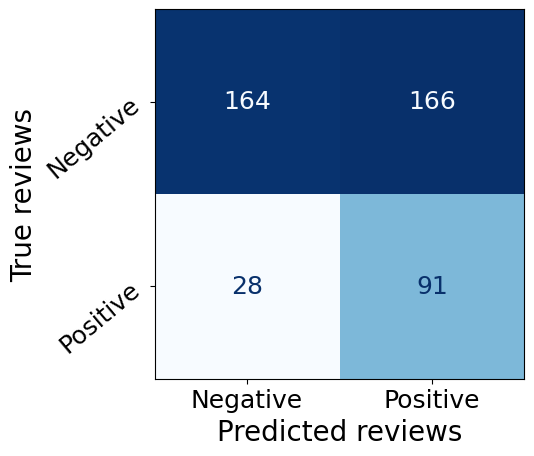

In [20]:
cm_svm = ConfusionMatrixDisplay.from_estimator(classifier_naive, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()

In [20]:
prediction_svm = svm.predict(X_test) 
print(classification_report(test_y, prediction_svm))

              precision    recall  f1-score   support

           0       0.86      0.37      0.51       330
           1       0.32      0.84      0.47       119

    accuracy                           0.49       449
   macro avg       0.59      0.60      0.49       449
weighted avg       0.72      0.49      0.50       449



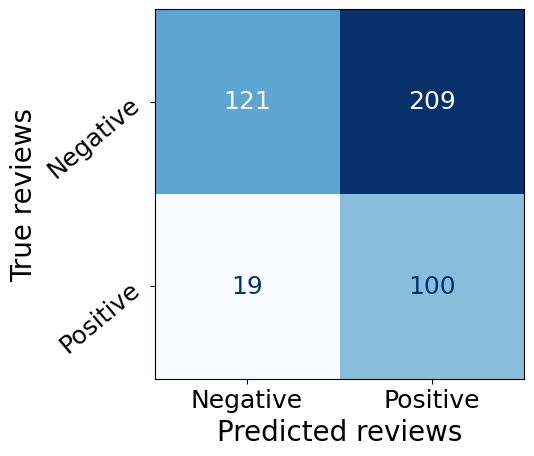

In [22]:
cm_svm = ConfusionMatrixDisplay.from_estimator(svm, X_test, test_y, display_labels=['Negative', 'Positive'], cmap='Blues', colorbar=False)
plt.yticks(rotation=40)
plt.ylabel('True reviews', fontsize=20)
plt.xlabel('Predicted reviews', fontsize=20)
plt.show()

### All data

In [21]:
train_x, test_x, train_y, test_y = train_test_split(df_whiskey.description, df_whiskey.points, test_size=0.99, random_state=50)

In [22]:
X_train = cv.transform(train_x)
X_test = cv.transform(test_x)

In [23]:
prediction_naive = classifier_naive.predict(X_test)
print(classification_report(test_y, prediction_naive))

              precision    recall  f1-score   support

           0       0.89      0.51      0.65      1661
           1       0.36      0.81      0.50       562

    accuracy                           0.58      2223
   macro avg       0.62      0.66      0.57      2223
weighted avg       0.75      0.58      0.61      2223



In [24]:
prediction_naive = svm.predict(X_test)
print(classification_report(test_y, prediction_naive))

              precision    recall  f1-score   support

           0       0.89      0.35      0.50      1661
           1       0.31      0.87      0.46       562

    accuracy                           0.48      2223
   macro avg       0.60      0.61      0.48      2223
weighted avg       0.75      0.48      0.49      2223

